In [34]:
# Importing libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd # Loading CSV files and data manipulation
import numpy as np # Just for the heck of it
import scipy.stats as stats # fitting gamma distribution

In [362]:
# Inputs
dataFolder = "~abbas/Documents/Projects_Repositories/Sales_Prediction/data/"
customersFile = "customers.csv"
finalSalesFile = "final_sales.csv"
productsFile = "products.csv"
transactionsFile = "transactions.csv"
cleanup_nums = {'A ': 23,
                'B ': 27,
                'C ': 32,
                'D ': 37,
                'E ': 42,
                'F ': 47,
                'G ': 52,
                'H ': 57,
                'I ': 62,
                'J ': 67,
                'K ': 67}

In [402]:
# Reading CSV files
customers = pd.read_csv(dataFolder + customersFile)
finalSales = pd.read_csv(dataFolder + finalSalesFile)
products = pd.read_csv(dataFolder + productsFile)
transactions = pd.read_csv(dataFolder + transactionsFile)

In [403]:
customers['age_group'].replace(cleanup_nums, inplace=True)
customers['age_group'] = customers['age_group'].astype(str).astype(int)
customers['residence_area_code'] = customers['residence_area_code'].astype('category')
customers['BMI'] = customers.weight_lb*0.45 / (customers.height_inchess*0.025)**2
print(customers.dtypes)

customer_id               int64
age_group                 int64
residence_area_code    category
weight_lb               float64
height_inchess          float64
BMI                     float64
dtype: object


In [393]:
# Useful functions
def change_aggregated_columns(df):
    '''
    *** This function changes the column names when we have aggregated pandas dataframe and we want to get rid of 
        two names. For example, we might have df['Temperature']['mean'] and df['Temperature']['std']. This function 
        changes them into df['Temperature_mean'] and df['Temperature_std']
    NOTE: In this project, we are not using this function. Please keep it as it wil be useful in the future...
    '''
    myColumns = df.columns.tolist()
    dfModified = pd.DataFrame({})
    n = len(myColumns)
    for i in range(n):
        if len(myColumns[i][1]) > 0:
            dfModified[myColumns[i][0] + "_" + myColumns[i][1]] = df[myColumns[i][0]][myColumns[i][1]]
        else:
            dfModified[myColumns[i][0]] = df[myColumns[i][0]]
    return dfModified

def date_range(arr):     
    return (arr.iloc[-1] - arr.iloc[0])

def last_date(arr):     
    return arr.iloc[-1]

def num_date(arr):     
    return len(arr)

In [394]:
# Data Quality Check:
print("finalSales costumer_id are all unique:", len(finalSales.customer_id.unique()) == finalSales.shape[0])

finalSales costumer_id are all unique: True


In [401]:
print(" --- Area code ddistribution: ")
print(customers["residence_area_code"].value_counts())
print(" ---- Age distribution: ")
print(customers["age_group"].value_counts())

 --- Area code ddistribution: 
E     10803
F      8542
G      3701
C      3689
D      2169
H      1453
A       972
B       937
Name: residence_area_code, dtype: int64
 ---- Age distribution: 
37    6588
32    5916
42    5084
47    3723
27    3196
52    2184
67    1989
23    1630
57    1076
62     880
Name: age_group, dtype: int64


In [396]:
finalSales.sort_values(by = 'sales_price', ascending = False).head()

,customer_id,sales_price,transaction_date
14973,1622362,444000,2001-02-17
28607,2103679,43917,2000-12-07
12484,1504491,29344,2001-01-21
29760,2133461,24795,2001-01-16
29663,2131214,24795,2001-01-16


alpha:  320.746636447  loc:  -6.64600294058  beta:  0.0292536376561


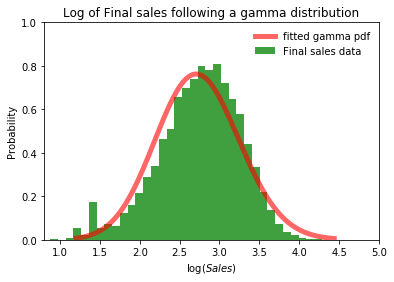

In [55]:
n, bins, patches = plt.hist(np.log10(finalSales.sales_price), bins=50, normed= True, facecolor='green', 
                            alpha=0.75, label = "Final sales data")

fit_alpha, fit_loc, fit_beta=stats.gamma.fit(np.log10(finalSales.sales_price))
x = np.linspace(stats.gamma.ppf(0.001, fit_alpha, loc = fit_loc, scale = fit_beta), 
                stats.gamma.ppf(0.999, fit_alpha, loc = fit_loc, scale = fit_beta), 10000)
plt.plot(x, stats.gamma.pdf(x, fit_alpha, loc = fit_loc, scale = fit_beta),'r-', lw=5, alpha=0.6, 
         label='fitted gamma pdf')
print("alpha: ", fit_alpha, " loc: ", fit_loc, " beta: ", fit_beta)
# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)
plt.xlabel('$\log(Sales)$')
plt.ylabel('Probability')
plt.title('Log of Final sales following a gamma distribution')
plt.axis([0.8, 5, 0, 1])
plt.legend(loc='best', frameon=False)
plt.show()

In [404]:
transactions['product_price'] = transactions.sales_price / transactions.quantity
transactions = transactions.sort_values(by = ['customer_id', 'transaction_date'], ascending = True)
transactions = transactions.merge(products, on= "product_id", how='left')
transactions['percentage_locally_sourced'] = transactions.locally_sourced * transactions.sales_price
transactionsGrouped = transactions.groupby(['customer_id',
                               'transaction_date']).agg({'product_class':pd.Series.nunique, 
                                                         'weight_class':pd.Series.nunique,
                                                         'color_code':pd.Series.nunique,
                                                         'sales_price':sum,
                                                         'quantity':sum,
                                                         'percentage_locally_sourced':sum,
                                                         'product_price':'mean'})[['product_class',
                                                                                   'weight_class',
                                                                                   'color_code',
                                                                                   'sales_price',
                                                                                   'quantity',
                                                                                   'percentage_locally_sourced',
                                                                                   'product_price']]
transactionsGrouped['percentage_locally_sourced'] = transactionsGrouped.percentage_locally_sourced / transactionsGrouped.sales_price
transactionsGrouped = transactionsGrouped.reset_index()
transactionsGrouped = transactionsGrouped.groupby("customer_id", as_index=False).apply(lambda x: x.iloc[:-1])
transactionsGrouped = transactionsGrouped.reset_index()
transactionsGrouped['transaction_date'] = pd.to_datetime(transactionsGrouped['transaction_date'], format='%Y-%m-%d')
transactionsGrouped2 = transactionsGrouped.groupby('customer_id').agg({'transaction_date': [date_range, last_date],
                                                                       'product_class': 'mean',
                                                                       'weight_class': 'mean',
                                                                       'color_code': 'mean',
                                                                       'sales_price': ['mean', max, num_date],
                                                                       'quantity': 'mean',
                                                                       'percentage_locally_sourced': 'mean',
                                                                       'product_price': 'mean'})
transactionsGrouped2 = transactionsGrouped2.reset_index()
transactionsGrouped2 = change_aggregated_columns(transactionsGrouped2)
transactionsGrouped2['transaction_date_date_range'] = transactionsGrouped2['transaction_date_date_range'].dt.days
transactionsGrouped2 = transactionsGrouped2.merge(customers, on= "customer_id", how='left')

In [408]:
transactionsGrouped2.head()

,customer_id,transaction_date_date_range,transaction_date_last_date,sales_price_mean,sales_price_max,sales_price_num_date,percentage_locally_sourced_mean,product_class_mean,weight_class_mean,color_code_mean,product_price_mean,quantity_mean,age_group,residence_area_code,weight_lb,height_inchess,BMI
0,1069,82,2001-02-03,551.333333,971,3,0.470228,3.000000,2.666667,2.333333,157.922222,4.666667,67,E,168.667742,75.119849,21.520637
1,1113,15,2000-11-27,534.000000,624,3,0.007479,3.666667,3.000000,2.666667,120.805556,4.666667,67,F,248.964319,67.625904,39.196152
2,1250,0,2001-02-04,734.000000,734,1,0.420981,3.000000,4.000000,2.000000,171.250000,5.000000,37,D,246.760186,62.941846,44.846509
3,1823,4,2000-11-06,1087.000000,1256,2,0.525407,3.500000,3.500000,3.500000,126.888889,11.000000,67,D,193.430925,69.043059,29.215839
4,2189,0,2000-12-02,9078.000000,9078,1,0.138356,30.000000,8.000000,6.000000,101.487805,89.000000,67,B,217.055635,69.622813,32.240400


In [409]:
transactionsGrouped2.shape

(20388, 17)

In [410]:
finalSales.shape

(32266, 3)